<hr>
<font size=5 color='#217638'> <b> Flower Recognition ConvNet from Scratch </b> </font> 
<hr/>

1. [Importing Libraries and Reading the Dataset](#1)
2. [Building the Network](#2)
    * [Configuring the Model for Training](#3)
    * [Data Augmentation](#4)
    * [Displaying Some Augmented Images](#5)
    * [Fitting the model](#6)
    * [Saving the model](#7)
    * [Displaying curves of loss and accuracy during training](#8)
3. [Conclusion](#9)

## <span id="1"></span> 1. Importing Libraries and Reading the Dataset
The images dataset are not seperated into training and test set. In this section, we are going to copy images and divide into two folder (train and validation). I have added detailed folder list that you can see later. But simply, the folder will bel like this:
```
data/
    train/
        category1/(contains all images related to category1)  
        category2/(contains all images related to category2)
        ...
        ...
            
    validation/
        category1/(contains all images related to category1)  
        category2/(contains all images related to category2)
        ...
        ...
```

In [1]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


In [2]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

Original folder list is here as you can see below. But we need a training and test set. Let's get them.
```
/kaggle/input/flowers-recognition/
    flowers/
        tulip
        daisy
        sunflower
        rose
        dandelion
```

In [3]:
# original dataset folder, you can see above
input_path = Path('/kaggle/input/flowers-recognition/flowers')
flowers_path = input_path / 'flowers'

In [4]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['daisy', 'rose', 'dandelion', 'sunflower', 'tulip']


In [5]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,daisy,/kaggle/input/flowers-recognition/flowers/flow...
1,daisy,/kaggle/input/flowers-recognition/flowers/flow...
2,daisy,/kaggle/input/flowers-recognition/flowers/flow...
3,daisy,/kaggle/input/flowers-recognition/flowers/flow...
4,daisy,/kaggle/input/flowers-recognition/flowers/flow...


This cell above, creating a dataframe which contains all images and their path. If we run this command to see first row's image path:
```
>> flowers['image'][0]
```

The output:
```
'/kaggle/input/flowers-recognition/flowers/tulip/122450705_9885fff3c4_n.jpg'
```


In [6]:
# feel free to edit "0" (corresponds 0. image)
# flowers['image'][0]

In [7]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  4326
Flowers in each category: 
dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: category, dtype: int64


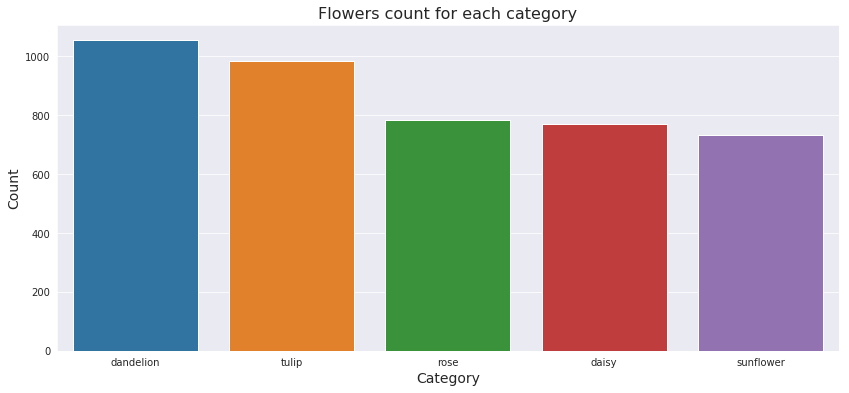

In [8]:
# Let's do some visualization and see how many samples we have for each category

f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = fl_count.index, y = fl_count.values, ax = axe)
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

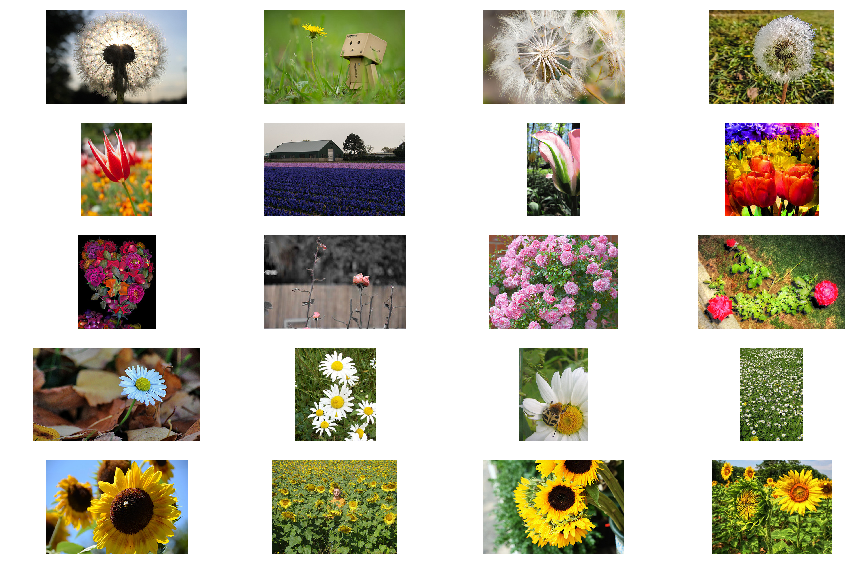

In [9]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

In [10]:
# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulip
%mkdir -p train/sunflower
%mkdir -p train/rose
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulip
%mkdir -p valid/sunflower
%mkdir -p valid/rose
%mkdir -p valid/dandelion

%cd ..

# You can verify that everything went correctly using ls command

/kaggle/working/data
/kaggle/working


Now, it's time to prepare our training and test sets. This code below copying files into new folders and creating new images stored like below.
```
data/
    train/
        daisy  
        dandelion
        rose
        sunflower
        tulip
            
    validation/
        daisy  
        dandelion
        rose
        sunflower
        tulip
```

In [11]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory
    for i in range(100):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(101,len(perm)):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/train/' + str(category) + '/' + name)

If you are familiar with **cd** and **ls** commands, you can see new folders and image files by using them.

## <span id="2"></span> 2. Building the Network

I have designed a diagram in order to visualize the architecture of model. If you're comfortable about theoretical knowledge of Convolutional Neural Networks, hope this make sense. But I know that there are many practitioners on Kaggle, hey guys, just scroll down! :)
<img src="https://docs.google.com/uc?id=1aipvkky5CyHQx2vyYoUdqAdRuaX1YSJi" width="850px">

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(240, 240, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)      

### <span id="3"></span> Configuring the Model for Training

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### <span id="4"></span> Data Augmentation

Because we have a very small dataset (4242 samples), data augmentation can help to improve accuracy. But also we need to rescale images. All these processes coded in this cell below.

In [14]:
# Define the generators
batch_size = 32
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(240, 240),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical')

Found 3819 images belonging to 5 classes.
Found 499 images belonging to 5 classes.


### <span id="5"></span> Displaying Some Augmented Images

Let's visualize an augmanted image and see what we got!

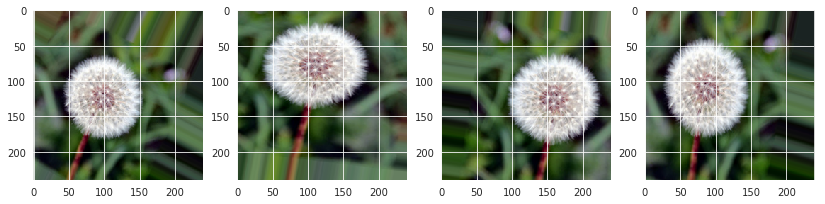

In [15]:
from keras.preprocessing import image
fnames = [os.path.join('data/train/dandelion', fname) for
fname in os.listdir('data/train/dandelion')]
img_path = fnames[22]
img = image.load_img(img_path, target_size=(240, 240))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
f, axes = plt.subplots(1,4,figsize=(14,4))
for batch in train_datagen.flow(x, batch_size=1):
    imgplot = axes[i].imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

### <span id="6"></span> Fitting the Model

In [16]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch=100,
          epochs=100,
          validation_data=validation_generator,
          validation_steps=50)

Epoch 1/100
100/100 [==============================] - 52s 522ms/step - loss: 1.4282 - acc: 0.3671 - val_loss: 1.3360 - val_acc: 0.3997
Epoch 2/100
100/100 [==============================] - 48s 477ms/step - loss: 1.2581 - acc: 0.4555 - val_loss: 1.3576 - val_acc: 0.5176
Epoch 3/100
100/100 [==============================] - 47s 468ms/step - loss: 1.1706 - acc: 0.5046 - val_loss: 1.1013 - val_acc: 0.5311
Epoch 4/100
100/100 [==============================] - 47s 469ms/step - loss: 1.1076 - acc: 0.5403 - val_loss: 1.0345 - val_acc: 0.5740
Epoch 5/100
100/100 [==============================] - 47s 474ms/step - loss: 1.0787 - acc: 0.5672 - val_loss: 1.1946 - val_acc: 0.5746
Epoch 6/100
100/100 [==============================] - 47s 470ms/step - loss: 1.0448 - acc: 0.5766 - val_loss: 1.3783 - val_acc: 0.6515
Epoch 7/100
100/100 [==============================] - 47s 474ms/step - loss: 1.0140 - acc: 0.6049 - val_loss: 0.6105 - val_acc: 0.6355
Epoch 8/100
100/100 [===========================

### <span id="7"></span> Saving the model

In [17]:
model.save('flowers_recognition_v2.h5')

### <span id="8"></span> Displaying curves and accuracy during training

Building a ConvNet from scratch is not the best method to get the best accuracy. However, we are learning, so be cool!

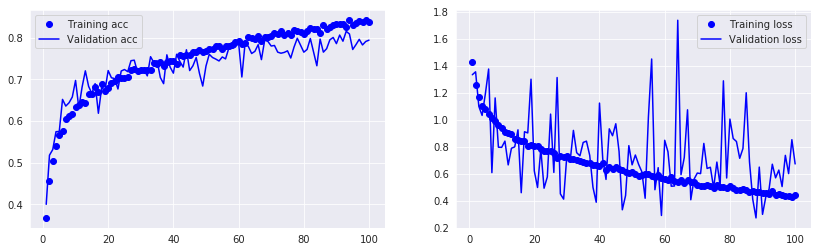

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [19]:
# deleting train and test sets, because kaggle is trying to show all
# images that we created as output
shutil.rmtree("/kaggle/working/data")

## <span id="9"></span> 4. Conclusion

In this kernel, I have built a ConvNet from scratch using [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) data. My goal wasn't to get the best accuracy, but to learn about ConvNet in Keras. Using pre-trained models (transfer learning) can give better results.